<a href="https://colab.research.google.com/github/explainpark101/2025-2-DL/blob/main/reinforced_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create Environment of Blackjack

In [28]:
!pip install "gymnasium>=1.2.2"

In [29]:
from dataclasses import dataclass
from gymnasium.envs.toy_text.blackjack import BlackjackEnv as InfiniteDeckBlackjackEnv

@dataclass
class BlackJackRewards:
    BUST: float = -5.0
    LOSS: float = -3.0
    WIN: float = 3.0
    NATURAL_BLACKJACK: float = 4.5
    DRAW: float = 0.0

class BlackjackEnv(InfiniteDeckBlackjackEnv):
    def __init__(self, render_mode=None, num_decks=6, rewards: BlackJackRewards = BlackJackRewards(), natural=True, sab=False):
        # 부모 클래스 초기화 (기본 설정 유지)
        super().__init__(render_mode=render_mode, sab=sab, natural=natural)

        self.num_decks = num_decks
        self.deck = []
        self.reshuffle_deck()

        self.rewards = rewards

    def reshuffle_deck(self):
        # 1~13 (A~K) 카드를 4무늬 * N덱 만큼 생성
        # Gymnasium Blackjack은 J,Q,K를 모두 10으로 처리하므로 그에 맞춰 구성
        # 1(Ace), 2~9, 10(10,J,Q,K) 비율 반영
        deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4 * self.num_decks
        self.np_random.shuffle(deck)
        self.deck = deck

    def step(self, action):
        next_state, original_reward, terminated, truncated, info = super().step(action)

        final_reward = original_reward

        # 게임이 끝난 경우(terminated)에만 보상 수정 로직 적용
        if terminated or truncated:
            if action == 1: # 상황 1: Hit(1)을 했는데 게임이 끝남 -> 무조건 Bust
                final_reward = self.rewards.BUST

            elif action == 0: # 상황 2, 3, 4: Stay(0)를 해서 게임이 끝남 -> 결과 비교
                if original_reward == 1.5: # natural blackjack
                    final_reward = self.rewards.NATURAL_BLACKJACK
                elif original_reward > 0:
                    final_reward = self.rewards.WIN
                elif original_reward < 0:
                    final_reward = self.rewards.LOSS
                else:
                    final_reward = self.rewards.DRAW

        return next_state, final_reward, terminated, truncated, info

    def draw_card(self):
        if len(self.deck) < 1: # 댁 다 쓰면 다음 라운드
            self.reshuffle_deck()
        return self.deck.pop()

    def reset(self, seed=None, options=None):
        # 덱 초기화가 필요하면 여기서 처리
        return super().reset(seed=seed, options=options)

# Create Neural Network and Replay Buffer Class

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
from tqdm import tqdm

In [31]:
class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()
        # Input: Player Sum, Dealer Card, Usable Ace (3 dim)
        self.fc = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2) # Output: Stay(0), Hit(1)
        )

    def forward(self, x):
        return self.fc(x)

In [32]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

In [33]:
class DDQNAgent:
    def __init__(self, device):
        self.device = device
        self.policy_net = QNetwork().to(device)
        self.target_net = QNetwork().to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=0.001)
        self.memory = ReplayBuffer(10000)

        self.batch_size = 64
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

    def preprocess(self, state):
        # Tuple State (Sum, Dealer) -> Tensor
        # Ace는 boolean이므로 float으로 변환
        state_arr = np.array([state[0], state[1], state[2]], dtype=np.float32)
        return torch.FloatTensor(state_arr).unsqueeze(0).to(self.device)

    def act(self, state):
        if random.random() < self.epsilon:
            return random.choice([0, 1])
        else:
            with torch.no_grad():
                state_t = self.preprocess(state)
                q_values = self.policy_net(state_t)
                return torch.argmax(q_values).item()

    def train(self):
        if len(self.memory) < self.batch_size:
            return 0.0
        states: tuple[int, int]
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        # Convert to Tensor
        states = torch.FloatTensor(np.array([
            [s[0], s[1], s[2]] for s in states
        ])).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(np.array([
            [ns[0], ns[1], ns[2]] for ns in next_states
        ])).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        # DDQN Logic
        # 1. Main Net에서 다음 상태의 최적 행동 선택 (argmax)
        with torch.no_grad():
            next_actions = self.policy_net(next_states).argmax(1).unsqueeze(1)
            # 2. Target Net에서 그 행동의 Q값 계산
            next_q_values = self.target_net(next_states).gather(1, next_actions)
            # 3. Target 값 계산
            target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

        # Current Q
        current_q_values = self.policy_net(states).gather(1, actions)

        # Compute Loss & Update
        loss = nn.MSELoss()(current_q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def update_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def update_target_net(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

# Learning

In [41]:
device = "cuda" if torch.cuda.is_available() else "cpu"
rewards = BlackJackRewards(
    BUST = -5.0,
    LOSS = -3.0,
    WIN = 3.0,
    NATURAL_BLACKJACK = 3.5,
    DRAW = 0.0
)
env = BlackjackEnv(num_decks=6, rewards=rewards, natural=True, sab=True)
agent = DDQNAgent(device)

num_episodes = 50_000
target_update_freq = 100


recent_rewards = deque(maxlen=100)
recent_losses = deque(maxlen=100)

# progress bar | not for learning, but for visualization of learning
pbar = tqdm(range(num_episodes), desc="Training", unit="ep", mininterval=1.0)


Training:   0%|          | 0/50000 [00:00<?, ?ep/s]

In [42]:
def train():
    for episode in pbar:
        state, _ = env.reset()
        done = False
        total_reward = 0
        loss = 0

        while not done:
            action = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.memory.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            loss = agent.train()

        # Update params
        agent.update_epsilon()
        if episode % target_update_freq == 0:
            agent.update_target_net()

        # Logging
        recent_rewards.append(total_reward)
        if loss != 0: recent_losses.append(loss)

        avg_reward = np.mean(recent_rewards) if recent_rewards else 0.0
        avg_loss = np.mean(recent_losses) if recent_losses else 0.0

        # tqdm bar update
        if episode % 100 == 0:
            pbar.set_postfix({
                'Avg Reward': f'{avg_reward:.2f}',
                'Loss': f'{avg_loss:.4f}',
                'Eps': f'{agent.epsilon:.2f}'
            })
train()

Training:   3%|▎         | 1727/50000 [00:06<03:00, 267.53ep/s, Avg Reward=0.17, Loss=5.6746, Eps=0.01]


KeyboardInterrupt: 

## Model Save

In [36]:
# torch.save(agent.policy_net.state_dict(), "ddqn_blackjack.pth")

# Test

In [37]:
import torch
import numpy as np

# --- 1. Load Model & Environment ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = QNetwork().to(device)

try:
    model.load_state_dict(torch.load("ddqn_blackjack.pth"))
except FileNotFoundError:
    print("모델 파일이 없습니다. 학습을 먼저 진행해주세요.")
    exit()

model.eval() # 평가 모드 (Dropout/BatchNorm 등 비활성화)
env = BlackjackEnv(num_decks=6, rewards=rewards)

# --- 2. Helper Function for Inference ---
def get_ai_action(state):
    # State: (PlayerSum, DealerShow, UsableAce)
    state_arr = np.array([state[0], state[1], state[2]], dtype=np.float32)
    state_t = torch.FloatTensor(state_arr).unsqueeze(0).to(device)

    with torch.no_grad():
        q_values = model(state_t)
        return torch.argmax(q_values).item() # 0: Stay, 1: Hit

# --- 3. Testing Loop ---
def test_play(num_games=10, print_result=False):
    wins = 0
    draws = 0
    losses = 0
    if not print_result:
        def print(*args, **kwargs):
            pass
    print(f"\n--- AI 상세 테스트 시작 ({num_games} 게임) ---")

    for i in range(num_games):
        state, _ = env.reset()
        done = False
        print(f"\n[Game {i+1}]")

        # Player Turn
        while not done:
            player_sum, dealer_show, usable_ace = state

            # --- 수정된 부분: 현재 패 정보를 env 객체에서 직접 가져옴 ---
            current_player_hand = env.player  # 예: [10, 5]

            action = get_ai_action(state)
            action_str = "Hit" if action == 1 else "Stay"

            print(f"  Turn: Player {current_player_hand} ({player_sum}) vs Dealer Show [{dealer_show}] -> Action: {action_str}")

            if action == 0: # Stay
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
            else: # Hit
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated

            state = next_state

        # --- Game Over: 최종 결과 및 딜러의 숨겨진 패 공개 ---
        card_map = {
            1: 'A',
            11: 'J',
            12: 'Q',
            13: "K",
            **{i:i for i in range(2, 11)}
        }
        final_player_hand = env.player
        final_dealer_hand = env.dealer # 게임이 끝나면 딜러의 모든 카드가 공개됨
        final_player_hand_show = list(card_map.get(card) for card in env.player)
        final_dealer_hand_show = list(card_map.get(card) for card in env.dealer) # 게임이 끝나면 딜러의 모든 카드가 공개됨

        # 승패 판정 로직
        if reward == rewards.NATURAL_BLACKJACK or reward == rewards.WIN:
            result = "WIN"
            wins += 1
        elif reward == rewards.LOSS or reward == rewards.BUST:
            result = "LOSS"
            losses += 1
        elif reward == rewards.DRAW:
            result = "DRAW"
            draws += 1
        else:
            raise ValueError(f"Invalid reward: {reward}")

        print(f"  Result: {result} (Reward: {reward})")
        print(f"  >> Final Hands: Player {final_player_hand_show} ({sum(final_player_hand)}) vs Dealer {final_dealer_hand_show} ({sum(final_dealer_hand)})")

    # --- Final Stats ---
    print("\n" + "="*30)
    print(f"총 전적: {wins}승 {draws}무 {losses}패")
    print(f"승률: {wins/num_games*100:.1f}% (무승부 포함 {(wins+draws)/num_games*100:.1f}%)")
    print("="*30)
    return wins/num_games
def main():
    total_days = 10
    win_rates = []
    for _ in range(total_days):
        win_rate = test_play(30, print_result=False)
        win_rates.append(win_rate)
    print(f"{total_days}테이블 동안의 승률: {np.mean(win_rates)*100:.1f}%")
    print(f"최고 승률: {max(win_rates)*100:.1f}%")
    print(f"최저 승률: {min(win_rates)*100:.1f}%")

if __name__ == "__main__":
    pass
    # main()

# Startegy Heatmap

In [38]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- 1. Load Model ---
# (QNetwork 클래스가 정의되어 있어야 함)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = QNetwork().to(device)
def main():
    try:
        model.load_state_dict(torch.load("ddqn_blackjack.pth"))
        model.eval()
    except FileNotFoundError:
        print("모델 파일이 없습니다.")
        exit()

    def get_best_action(player_sum, dealer_card, usable_ace):
        # Model Input: [PlayerSum, DealerCard, UsableAce]
        state = torch.FloatTensor([player_sum, dealer_card, int(usable_ace)]).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = model(state)
            return torch.argmax(q_values).item() # 0: Stay, 1: Hit

    # --- 2. Generate Strategy Grids ---
    # Dealer Card: 1(Ace) ~ 10
    dealer_cards = range(1, 11)
    dealer_labels = ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10']

    # Hard Hand: Player Sum 4 ~ 21 (Ace 없음 or Ace=1)
    hard_sums = range(21, 3, -1) # 21부터 4까지 역순 (그래프 위쪽이 높은 숫자)
    hard_grid = []

    for p_sum in hard_sums:
        row = []
        for d_card in dealer_cards:
            action = get_best_action(p_sum, d_card, usable_ace=False)
            row.append(action)
        hard_grid.append(row)

    # Soft Hand: Player Sum 12 ~ 21 (Usable Ace 존재)
    soft_sums = range(21, 11, -1)
    soft_grid = []

    for p_sum in soft_sums:
        row = []
        for d_card in dealer_cards:
            action = get_best_action(p_sum, d_card, usable_ace=True)
            row.append(action)
        soft_grid.append(row)

    # --- 3. Plot Heatmaps ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Helper to plot
    def plot_strategy(ax, grid, y_labels, title):
        sns.heatmap(grid, cmap="coolwarm_r", annot=True, fmt="d", cbar=False,
                    xticklabels=dealer_labels, yticklabels=y_labels,
                    linewidths=.5, ax=ax)
        ax.set_title(title, fontsize=15)
        ax.set_xlabel("Dealer Show Card")
        ax.set_ylabel("Player Sum")
        # 0(Red/Stay), 1(Blue/Hit)

    plot_strategy(axes[0], hard_grid, hard_sums, "Hard Hand Strategy (No Usable Ace)")
    plot_strategy(axes[1], soft_grid, soft_sums, "Soft Hand Strategy (Usable Ace)")

    # Legend 추가
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#3b4cc0', label='Hit (1)'),
                    Patch(facecolor='#b40426', label='Stay (0)')]
    fig.legend(handles=legend_elements, loc='upper center', ncol=2, fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

if __name__ == "__main__":
    pass
    # main()

Training: 100%|██████████| 50000/50000 [03:15<00:00, 255.24ep/s, Avg Reward=-1.21, Loss=4.9339, Eps=0.01]


디스코드 전송 성공!


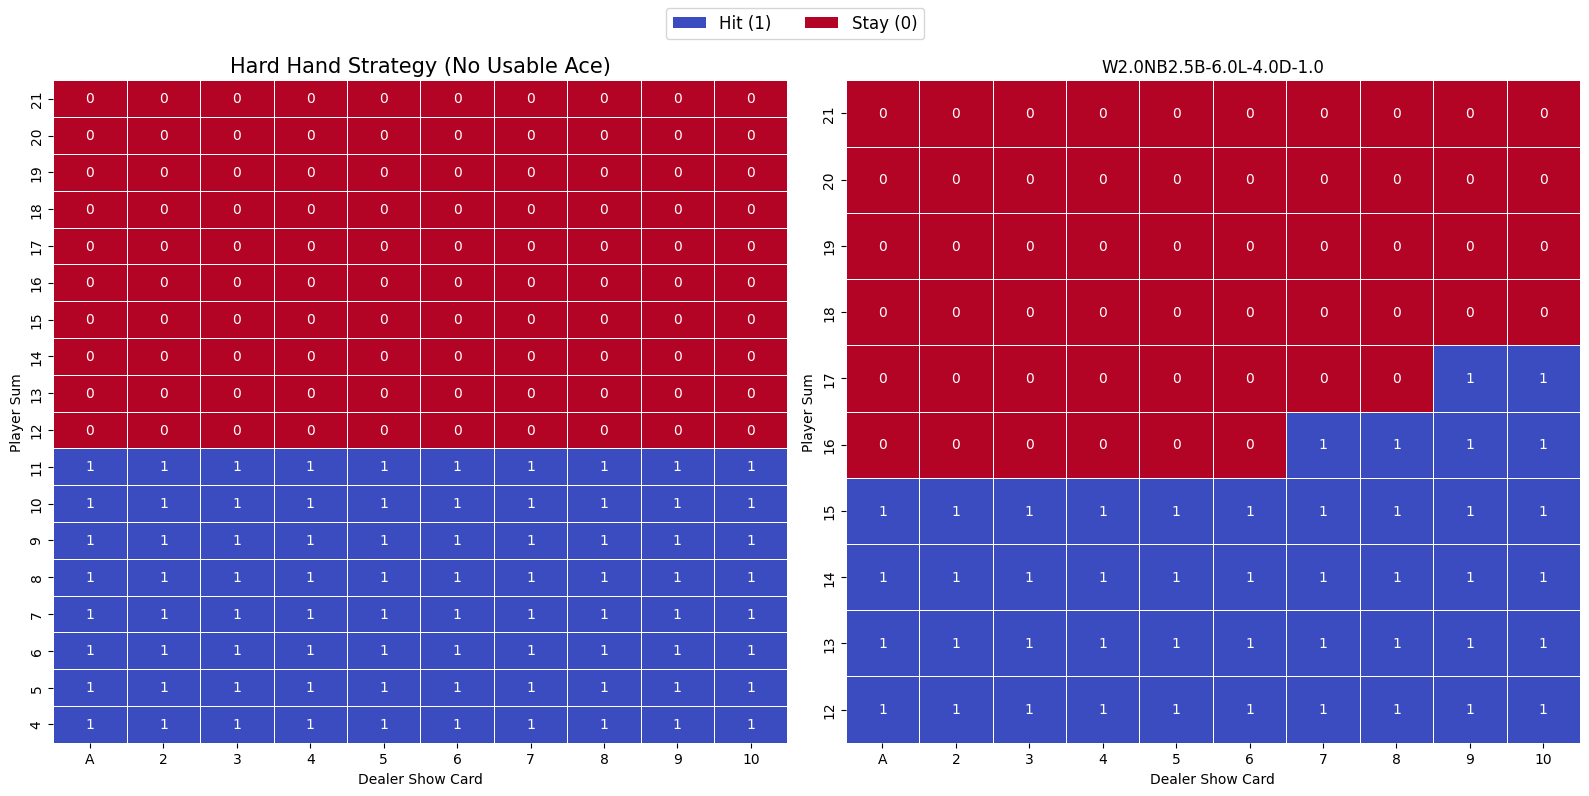

KeyboardInterrupt: 

In [47]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import io
DISCORD_WEBHOOK_URL = ""

def send_current_plot_to_discord(filename="plot.png", message="학습 그래프 전송"):
    """
    현재 plt에 그려진 그림을 메모리 버퍼에 저장 후 디스코드 웹훅으로 전송
    """
    # 1. 메모리 버퍼 생성
    buf = io.BytesIO()

    # 2. 그래프를 버퍼에 저장 (파일 생성 X)
    plt.savefig(buf, format='png', bbox_inches='tight')

    # 3. 파일 포인터를 맨 앞으로 이동 (필수)
    buf.seek(0)

    # 4. 디스코드 전송 (Multipart/form-data)
    files = {
        'file': (filename, buf, 'image/png')
    }
    data = {
        "content": message
    }

    try:
        response = requests.post(DISCORD_WEBHOOK_URL, data=data, files=files)
        if response.status_code == 200 or response.status_code == 204:
            print("디스코드 전송 성공!")
        else:
            print(f"디스코드 전송 실패: {response.status_code} - {response.text}")
    except Exception as e:
        print(f"전송 중 에러 발생: {e}")
    finally:
        # 5. 버퍼 닫기
        buf.close()
# env.rewards 별로 학습이 된 그래프 비교하기

device = "cuda" if torch.cuda.is_available() else "cpu"
agent = DDQNAgent(device)

num_episodes = 50_000
target_update_freq = 100


recent_rewards = deque(maxlen=100)
recent_losses = deque(maxlen=100)

# progress bar | not for learning, but for visualization of learning
pbar = tqdm(range(num_episodes), desc="Training", unit="ep", mininterval=1.0)
rewards = BlackJackRewards(
    BUST = -5.0,
    LOSS = -3.0,
    WIN = 3.0,
    NATURAL_BLACKJACK = 3.5,
    DRAW = 0.0
)
reward_diff_range = [-1, -.5, 0, .5, 1]
rewards_set = [
    BlackJackRewards(
        BUST = -5.0 + b,
        LOSS = -3.0 + l,
        WIN = 3.0 + w,
        NATURAL_BLACKJACK = 3.5 + n,
        DRAW = 0.0 + d
    ) for b in reward_diff_range
    for l in reward_diff_range
    for w in reward_diff_range
    for n in reward_diff_range
    for d in reward_diff_range
]
for rewards in rewards_set:
    env = BlackjackEnv(num_decks=6, rewards=rewards, natural=True, sab=True)
    train()
    weight = agent.policy_net.state_dict()


    # --- 1. Load Model ---
    # (QNetwork 클래스가 정의되어 있어야 함)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = QNetwork().to(device)

    try:
        model.load_state_dict(weight)
        model.eval()
    except FileNotFoundError:
        print("모델 파일이 없습니다.")
        exit()

    def get_best_action(player_sum, dealer_card, usable_ace):
        # Model Input: [PlayerSum, DealerCard, UsableAce]
        state = torch.FloatTensor([player_sum, dealer_card, int(usable_ace)]).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = model(state)
            return torch.argmax(q_values).item() # 0: Stay, 1: Hit

    # --- 2. Generate Strategy Grids ---
    # Dealer Card: 1(Ace) ~ 10
    dealer_cards = range(1, 11)
    dealer_labels = ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10']

    # Hard Hand: Player Sum 4 ~ 21 (Ace 없음 or Ace=1)
    hard_sums = range(21, 3, -1) # 21부터 4까지 역순 (그래프 위쪽이 높은 숫자)
    hard_grid = []

    for p_sum in hard_sums:
        row = []
        for d_card in dealer_cards:
            action = get_best_action(p_sum, d_card, usable_ace=False)
            row.append(action)
        hard_grid.append(row)

    # Soft Hand: Player Sum 12 ~ 21 (Usable Ace 존재)
    soft_sums = range(21, 11, -1)
    soft_grid = []

    for p_sum in soft_sums:
        row = []
        for d_card in dealer_cards:
            action = get_best_action(p_sum, d_card, usable_ace=True)
            row.append(action)
        soft_grid.append(row)

    # --- 3. Plot Heatmaps ---
    reward_title = f"W{rewards.WIN}NB{rewards.NATURAL_BLACKJACK}B{rewards.BUST}L{rewards.LOSS}D{rewards.DRAW}"
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Helper to plot
    def plot_strategy(ax, grid, y_labels, title):
        sns.heatmap(grid, cmap="coolwarm_r", annot=True, fmt="d", cbar=False,
                    xticklabels=dealer_labels, yticklabels=y_labels,
                    linewidths=.5, ax=ax)
        ax.set_title(title, fontsize=15)
        ax.set_xlabel("Dealer Show Card")
        ax.set_ylabel("Player Sum")
        # 0(Red/Stay), 1(Blue/Hit)

    plot_strategy(axes[0], hard_grid, hard_sums, "Hard Hand Strategy (No Usable Ace)")
    plot_strategy(axes[1], soft_grid, soft_sums, "Soft Hand Strategy (Usable Ace)")

    # Legend 추가
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#3b4cc0', label='Hit (1)'),
                    Patch(facecolor='#b40426', label='Stay (0)')]
    fig.legend(handles=legend_elements, loc='upper center', ncol=2, fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # title 추가
    fig.suptitle(reward_title, fontsize=24, fontweight='bold', y=0.98)

    send_current_plot_to_discord(f"ddqn_blackjack_{reward_title}.png", f"""weight 상태:
```
bust: {rewards.BUST}
loss: {rewards.LOSS}
natural_blackjack: {rewards.NATURAL_BLACKJACK}
win: {rewards.WIN}
draw: {rewards.DRAW}
```
""")
    # plt.show()
